# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.

In [1]:
import os
import torch
import numpy as np
import librosa
from scipy.io import wavfile
from scipy import fft
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-20 23:37:03.447969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 23:37:03.459934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737412623.485017    3785 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737412623.490164    3785 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 23:37:03.506060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training, validation, and test sets) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

# Define paths and parameters
DATASET_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH =  "/mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt" 

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).


In [3]:
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
RANDOM_STATE = 2159081 # For reproducibility
MAX_TIME_STEPS = 109  # Define the maximum time steps for your model

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and stored in a dictionary for easy retrieval. The function processes training, validation, and test datasets, and their label counts and examples are printed for verification.


In [4]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)
test_labels = load_labels(LABELS_TEST)
test_unseen_labels = load_labels(LABELS_UNSEEN_TEST)

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])
print("Number of validation samples:", len(test_labels))
print("Validation example label:", list(test_labels.items())[:5])
print("Number of testing samples:", len(test_unseen_labels))
print("Testing example label:", list(test_unseen_labels.items())[:5])

Number of training samples: 25380
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Number of validation samples: 24844
Validation example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]
Number of testing samples: 71237
Testing example label: [('LA_E_2834763', 'spoof'), ('LA_E_8877452', 'spoof'), ('LA_E_6828287', 'spoof'), ('LA_E_6977360', 'spoof'), ('LA_E_5932896', 'spoof')]


### Section 2.2: Separating Bonafide and Spoof Samples
This section introduces a function to separate bonafide and spoof samples within a dataset. It categorizes labels into two dictionaries, one for each class. The class distribution is printed to assess dataset balance.

In [5]:
# Separate bonafide and spoof samples of a dataset
def separate_bonafide_spoof_samples(dataset_labels):
    bonafide_samples = {k: v for k, v in train_labels.items() if v == 'bonafide'}
    spoof_samples = {k: v for k, v in train_labels.items() if v == 'spoof'}
    return bonafide_samples, spoof_samples

bonafide_train_samples, spoof_train_samples = separate_bonafide_spoof_samples(train_labels)

# Print counts
print(f"Training bonafide samples: {len(bonafide_train_samples)}")
print(f"Training spoof samples: {len(spoof_train_samples)}")

Training bonafide samples: 2580
Training spoof samples: 22800


### Section 2.3: Balancing the Dataset
This section introduces a method to balance the dataset by randomly sampling `spoof` samples to match the count of `bonafide` samples. The balanced dataset is created by combining the two subsets, ensuring class parity for training.


In [6]:
import random
random.seed(RANDOM_STATE)  # For reproducibility

# Balance the dataset by matching the number of spoof samples to bonafide samples
def balance_bonafide_spoof_samples(bonafide_samples, spoof_samples):
    spoof_keys = list(spoof_samples.keys())
    random.shuffle(spoof_keys)
    balanced_spoof_samples = {k: spoof_samples[k] for k in spoof_keys[:len(bonafide_samples)]}
    residual_spoof_samples = {k: spoof_samples[k] for k in spoof_samples if k not in balanced_spoof_samples}

    # Combine bonafide and balanced spoof samples
    balanced_dataset = {**bonafide_samples, **balanced_spoof_samples}

    return balanced_dataset, residual_spoof_samples

train_labels_balanced, train_spoof_residual_labels = balance_bonafide_spoof_samples(bonafide_train_samples, spoof_train_samples)

# Print final counts
print(f"Balanced training samples: {len(train_labels_balanced)}")
print("Example label:", list(train_labels_balanced.items())[:5])
print(f"Residual spoof training samples: {len(train_spoof_residual_labels)}")
print("Example label:", list(train_spoof_residual_labels.items())[:5])

Balanced training samples: 5160
Example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Residual spoof training samples: 20220
Example label: [('LA_T_1004644', 'spoof'), ('LA_T_1056709', 'spoof'), ('LA_T_1195221', 'spoof'), ('LA_T_1265032', 'spoof'), ('LA_T_1365409', 'spoof')]


### Section 2.4: Reduce data for test speed up

In [7]:
def shuffle_and_trim_dict(input_dict, n=10000):
    """
    Shuffle the input dictionary and return a new dictionary with the first n elements.

    Args:
        input_dict (dict): The dictionary to shuffle and trim.
        n (int): The number of elements to keep after shuffle. Default is 10,000.

    Returns:
        dict: A shuffled dictionary with up to n elements.
    """
    # Convert dictionary items to a list and shuffle
    items = list(input_dict.items())
    random.shuffle(items)

    # Trim the list to the first n elements and recreate the dictionary
    trimmed_dict = dict(items[:n])

    return trimmed_dict

# ATTENTION: Dataset limiting --------------------------------
#train_labels_balanced = shuffle_and_trim_dict(train_labels, n=4000)
test_labels = shuffle_and_trim_dict(test_labels, n=8000)
test_unseen_labels = shuffle_and_trim_dict(test_unseen_labels, n=100)
train_spoof_residual_labels = shuffle_and_trim_dict(train_spoof_residual_labels, n=100)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training samples:", len(train_labels_balanced))
print("Training example label:", list(train_labels_balanced.items())[:5])
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])
print("Number of testing (unseen) samples:", len(test_unseen_labels))
print("Testing example (unseen) label:", list(test_unseen_labels.items())[:5])
print("Number of spoof training residual samples:", len(train_spoof_residual_labels))
print("spoof training residual example label:", list(train_spoof_residual_labels.items())[:5])

Number of training samples: 5160
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]
Number of testing samples: 8000
Testing example label: [('LA_D_5800896', 'spoof'), ('LA_D_6261315', 'spoof'), ('LA_D_6974451', 'spoof'), ('LA_D_7168411', 'spoof'), ('LA_D_6231894', 'spoof')]
Number of testing (unseen) samples: 100
Testing example (unseen) label: [('LA_E_2015161', 'spoof'), ('LA_E_9472623', 'spoof'), ('LA_E_5329393', 'bonafide'), ('LA_E_8091846', 'spoof'), ('LA_E_6783160', 'spoof')]
Number of spoof training residual samples: 100
spoof training residual example label: [('LA_T_4438819', 'spoof'), ('LA_T_5100725', 'spoof'), ('LA_T_7071404', 'spoof'), ('LA_T_1416701', 'spoof'), ('LA_T_1905094', 'spoof')]


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and MEL Spectrogram Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to Mel spectrograms using `librosa`.
  - Standardize their dimensions using padding or trimming to fit a fixed time step (`MAX_TIME_STEPS`).
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [8]:
from tqdm import tqdm

# Function to load audio files and convert them to Mel spectrograms
def load_dataset_files(dataset_path, dataset_labels):
    """
    Loads audio files from a given dataset path, converts them to Mel spectrograms, 
    and ensures all spectrograms have the same size.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.

    Returns:
        X (np.array): Array of Mel spectrograms.
        y (np.array): Array of corresponding labels.
    """
    X = []
    y = []
    
    # Iterate over each file and its label
    for file_name, label in tqdm(dataset_labels.items(), desc="Loading and converting files"):
        file_path = os.path.join(dataset_path, file_name + ".flac")
        
        try:
            # Load audio file with librosa
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            
            X.append(audio)
            y.append(label)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return X, y

# Load the datasets
print("Loading training dataset...")
X_train, y_train = load_dataset_files(DATASET_TRAIN, train_labels_balanced)
print("Loading training dataset...")
X_train_spoof_residual, y_train_spoof_residual = load_dataset_files(DATASET_TRAIN, train_spoof_residual_labels)
print("Loading testing dataset...")
X_test, y_test = load_dataset_files(DATASET_TEST, test_labels)
print("Loading unseen testing dataset...")
X_unseen_test, y_unseen_test = load_dataset_files(DATASET_UNSEEN_TEST, test_unseen_labels)

# Verify shapes
#print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
#print(f"Training spoof residual data shape: {X_train_spoof_residual.shape}, Labels shape: {y_train_spoof_residual.shape}")
#print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")
#print(f"(Unseen) Testing data shape: {X_unseen_test.shape}, Labels shape: {y_unseen_test.shape}")

Loading training dataset...


Loading and converting files: 100%|████████████████████████████████████████████████| 5160/5160 [00:50<00:00, 101.22it/s]


Loading training dataset...


Loading and converting files: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 100.63it/s]


Loading testing dataset...


Loading and converting files: 100%|████████████████████████████████████████████████| 8000/8000 [00:47<00:00, 169.36it/s]


Loading unseen testing dataset...


Loading and converting files: 100%|███████████████████████████████████████████████████| 100/100 [00:01<00:00, 96.71it/s]


### Section 3.2: Function `plot_spect_from_sig_time`

This function calculates and visualizes the spectrogram of a time-domain signal. It splits the signal into fixed-size windows, computes the FFT for each window, and derives the power spectral density in decibels. The resulting spectrogram is displayed as a 2D image, with time on the x-axis and frequency on the y-axis.


In [9]:
def plot_spect_from_sig_time(data, rate, n=250):    
    # Spectrogram estimation:
    N = n
    S = []
    for k in range(0, data.shape[0]+1, N):
        x = fft.fftshift(fft.fft(data[k:k+N], n=N))[N//2:N]
        # assert np.allclose(np.imag(x*np.conj(x)), 0)
        Pxx = 10*np.log10(np.real(x*np.conj(x)))
        S.append(Pxx)
    S = np.array(S)
    
    # Frequencies:
    f = fft.fftshift(fft.fftfreq(N, d=1/rate))[N//2:N]
    
    # Spectrogram rendering:
    plt.imshow(S.T, origin='lower')

### Section 3.3: Function `plot_audio`

This function visualizes an audio signal by plotting its waveform and spectrogram.

#### What it does:
- **Waveform Plot:** Displays the amplitude of the audio signal over time using the `librosa.display.waveshow` function.
- **Spectrogram Plot (if added):** A representation of frequency content over time can also be added (currently not implemented in this code).

The visualization helps analyze the characteristics of the audio signal, such as amplitude variations and time structure.


In [10]:
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from IPython.display import display, Audio

def listen_to_audio(y, sr):
    """Plays the audio file."""
    display(Audio(y, rate=sr))

def plot_audio(y, sr):
  """Plots the waveform and spectrogram of an audio signal.

  Args:
      y: The audio time series.
      sr: The sampling rate of y.
  """
  plt.figure(figsize=(12, 6))

  # Plot the waveform
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(y, sr=sr)
  plt.title("Waveform")

  plt.tight_layout()
  plt.show()

### Section 3.4: Get Silence

This function provides a custom implementation for visualizing an audio waveform, similar to `librosa.display.waveshow`.

#### What it does:
- **Waveform Plotting:** 
  - If the audio duration is short, the full waveform is plotted using a step-based view.
  - For longer audio, it adapts by downsampling the signal and plotting an amplitude envelope.
- **Time Axis:** 
  - The x-axis represents time (in seconds) based on the signal's sampling rate and an optional offset.

#### Features:
- Adaptive rendering for efficient visualization of long audio signals.
- Uses a uniform filter to compute the amplitude envelope for downsampled data.

This function helps analyze both short and long audio signals while maintaining clarity and performance in the visualization.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

def custom_waveshow(y, sr=22050, max_points=11025, axis='time', offset=0.0, **kwargs):
    """
    Custom implementation of librosa.display.waveshow.
    
    Parameters:
    - y (ndarray): The audio signal (1D array).
    - sr (int): Sampling rate of the signal (default is 22050 Hz).
    - max_points (int): Maximum number of points for sample-based view (default is 11025 points).
    - axis (str): Units for the x-axis ('time' for seconds) (default is 'time').
    - offset (float): Offset start time for the waveform (default is 0.0).
    - **kwargs: Additional keyword arguments for matplotlib plotting.
    
    Returns:
    - None
    """
    
    # Initialize the envelope variable
    envelope = 0
    
    # Determine the total duration of the audio in seconds
    duration = len(y) / sr  # Length of the signal divided by sampling rate
    
    # Generate the time axis based on the signal length and the sampling rate
    time = np.arange(len(y)) / sr + offset

    # Adaptive rendering based on the total duration of the audio
    if duration <= max_points / sr:
        # If the duration is shorter, plot the waveform with a sample-based view
        plt.step(time, y, where="post", **kwargs)  # Step plot for waveform
    else:
        # If the audio is too long, downsample the signal for an amplitude envelope plot
        downsample_factor = max(1, len(y) // max_points)  # Calculate the factor to downsample the signal
        
        # Compute the amplitude envelope of the audio signal using a uniform filter
        envelope = uniform_filter1d(np.abs(y), size=downsample_factor)
        envelope_time = time[::downsample_factor]  # Create a time axis for the downsampled points

        # Prepare to plot the amplitude envelope
        fill_between_kwargs = kwargs.copy()  # Make a copy of the provided keyword arguments
        fill_between_kwargs.pop('alpha', None)  # Remove the 'alpha' key from kwargs to avoid conflict
        
        # Plot the amplitude envelope (this part is commented out for now)
        # plt.fill_between(
        #     envelope_time,  # Time for the downsampled points
        #     envelope,  # Amplitude envelope values
        #     -envelope,  # Negative values for the bottom part of the envelope
        #     alpha=0.6,  # Set transparency
        #     **fill_between_kwargs  # Pass the modified kwargs
        # )
    
    # Return the computed amplitude envelope (optional)
    return envelope


def extract_silence_from_audio(y, sr, threshold):
    """
    Extract the silence parts from the audio signal where the amplitude is lower than a given threshold.
    
    Parameters:
    - y (ndarray): The audio signal (1D array).
    - sr (int): Sampling rate of the signal.
    - threshold (float): Amplitude threshold for detecting silence.
    
    Returns:
    - C (ndarray): The silence portion of the signal (amplitude values lower than threshold).
    """
    
    # Get the amplitude envelope by calling custom_waveshow (it computes and returns the envelope)
    amplitude = custom_waveshow(y, sr=sr, max_points=11025, color="blue", alpha=0.8)
    
    # Initialize a temporary variable to hold the amplitude values
    tmp = amplitude
    
    # Create an array to store the silence values (set initially to zero)
    sil = np.zeros(len(tmp))
    
    # Counter variable to track the index of silence values
    counter = 0
    
    # Loop through the amplitude values to detect silence
    for i in range(0, len(tmp)):
        if tmp[i] < threshold:
            # If the amplitude is below the threshold, mark it as silence
            sil[counter] = tmp[i]
            counter += 1
    
    # Return the silence portion of the signal (sliced to the valid silence data)
    C = sil[:counter]
    return C

### Section 3.5: Extract silence from datasets

Processing audio files...


Processing:  96%|███████████████████████████████████████████████████████████████▎  | 4954/5160 [00:43<00:01, 115.35it/s]

Error: object of type 'int' has no len() at index 4939


Processing: 100%|██████████████████████████████████████████████████████████████████| 5160/5160 [00:45<00:00, 114.66it/s]


Padding and trimming...
Minimum silence length from training: 7332
Processing audio files...


Processing: 100%|██████████████████████████████████████████████████████████████████| 8000/8000 [01:11<00:00, 112.45it/s]


Padding and trimming...
Processing audio files...


Processing: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.55it/s]


Padding and trimming...


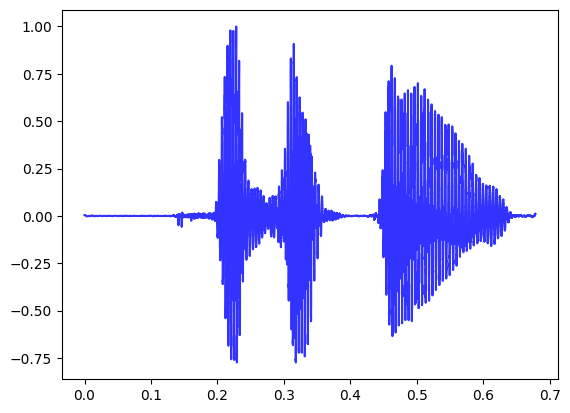

In [12]:
import numpy as np
from tqdm import tqdm  # For progress tracking

def process_audio_silence(audio_group, sample_rate, threshold=0.1, min_silence_length=None):
    """
    Process a group of audio files to extract, pad, and trim silence segments.

    Args:
        audio_group (list): List of audio signals to process.
        sample_rate (int): Sampling rate of the audio signals.
        threshold (float): Amplitude threshold for detecting silence (default: 0.1).
        min_silence_length (int, optional): If provided, ensures all silence segments are padded or trimmed to this length.

    Returns:
        list: Processed silence segments, padded and trimmed to uniform length.
        int: Minimum length of silence segments (if calculated).
        list: Indices of problematic audio entries (if any).
    """
    X = []  # Store silence segments
    cut_value = []  # Track problematic indices

    # Initialize min_length based on whether we're training or testing
    if min_silence_length is None:
        min_length = float('inf')  # Start with a very large value
    else:
        min_length = min_silence_length

    print("Processing audio files...")
    for count, audio in enumerate(tqdm(audio_group, desc="Processing")):
        try:
            # Extract silence from the audio
            silence = extract_silence_from_audio(audio, sample_rate, threshold)

            # Update the minimum length of silence if in training mode
            if min_silence_length is None and len(silence) < min_length:
                min_length = len(silence)

            # Append the silence segment to X
            X.append(silence)

        except TypeError as e:
            print(f"Error: {e} at index {count}")

            # Track the audio index that caused the error
            cut_value.append(count)

    # Padding and trimming the extracted silence segments
    print('Padding and trimming...')
    for idx, silence in enumerate(X):
        if len(silence) > min_length:
            # Truncate silence segments that are too long
            X[idx] = silence[:min_length]
        else:
            # Pad silence segments that are too short using Gaussian noise padding
            padding = np.random.normal(loc=0.0, scale=0.01, size=(min_length - len(silence)))
            X[idx] = np.concatenate((silence, padding))

    return X, (min_length if min_silence_length is None else min_silence_length), cut_value

# Process training data
X_train_silence, min_silence_length, errors_train = process_audio_silence(X_train, SAMPLE_RATE, threshold=0.1)
print(f"Minimum silence length from training: {min_silence_length}")
# Process test data using the minimum silence length from training
X_test_silence, _, errors_test = process_audio_silence(X_test, SAMPLE_RATE, threshold=0.1, min_silence_length=min_silence_length)
X_unseen_test_silence, _, errors_unseen_test = process_audio_silence(X_unseen_test, SAMPLE_RATE, threshold=0.1, min_silence_length=min_silence_length)

In [13]:
def remove_elements_by_indices(array, indices):
    # Converte l'elenco di indici in un set per una ricerca più veloce
    indices_set = set(indices)
    # Restituisce un nuovo array che contiene solo gli elementi i cui indici non sono in indices_set
    return [item for i, item in enumerate(array) if i not in indices_set]

# Esempio di utilizzo
array = [10, 20, 30, 40, 50]
indices = [1, 3]  # Rimuovi gli elementi agli indici 1 e 3

y_train_cleaned = remove_elements_by_indices(y_train, errors_train)
y_test_cleaned = remove_elements_by_indices(y_test, errors_test)
y_unseen_test_cleaned = remove_elements_by_indices(y_unseen_test, errors_unseen_test)


### Section 3.6: create arrays

In [14]:
X = np.array(X_train_silence)
y_temp = np.array(y_train_cleaned)
y = np.where(y_temp == "bonafide", 1, 0)

print(len(X))
print(len(y))

5159
5159


In [15]:
X_test_set = np.array(X_test_silence)
y_temp = np.array(y_test)
y_test_set = np.where(y_temp == "bonafide", 1, 0)

print(len(X_test_set))
print(len(y_test_set))

8000
8000


# 4. Define and train the CNN Model
### Section 4.1: Defining the CNN Model Architecture

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix

# Define 1D CNN for Silent Amplitude Analysis
class SilenceAnalysisCNN1D(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(SilenceAnalysisCNN1D, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate the size of the flattened feature map
        self.flattened_size = (sequence_length // 8) * 64

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass through convolutional layers + ReLU + pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Hyperparameters
input_channels = 1    # Single channel (amplitude)
sequence_length = min_silence_length # Length of silent amplitude sequence
num_classes = 2        # Number of classes (real or fake)
learning_rate = 0.001
batch_size = 32
epochs = 5

# Reshape input data to [Batch_Size, Channels, Sequence_Length]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 1, sequence_length)
y_tensor = torch.tensor(y, dtype=torch.int64)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = SilenceAnalysisCNN1D(input_channels, sequence_length, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for batch_X, batch_y in data_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Store predictions for metrics
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_targets.extend(batch_y.numpy())

    # Compute metrics
    accuracy = accuracy_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(data_loader):.4f}, Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

Epoch [1/5], Loss: 0.6937, Accuracy: 0.4993
Confusion Matrix:
[[ 360 2219]
 [ 364 2216]]

Epoch [2/5], Loss: 0.6534, Accuracy: 0.6075
Confusion Matrix:
[[1076 1503]
 [ 522 2058]]

Epoch [3/5], Loss: 0.5772, Accuracy: 0.7242
Confusion Matrix:
[[1261 1318]
 [ 105 2475]]

Epoch [4/5], Loss: 0.5638, Accuracy: 0.7385
Confusion Matrix:
[[1266 1313]
 [  36 2544]]

Epoch [5/5], Loss: 0.5629, Accuracy: 0.7441
Confusion Matrix:
[[1281 1298]
 [  22 2558]]



### Section 4.2: Save the model

In [17]:
# Save the state dictionary
torch.save(model.state_dict(), "MEL_CNN_Silence_BestModel.pth")
print("Model state dictionary saved.")


Model state dictionary saved.


# 5. Evalutate the model
### Section 5.1 Load the model

In [18]:
import torch
# Instantiate the model architecture
model = SilenceAnalysisCNN1D(input_channels, sequence_length, num_classes)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load("MEL_CNN_Silence_BestModel.pth", weights_only=True))

print("Model state dictionary loaded.")


Model state dictionary loaded.


### Section 5.2: Prepare testing

In [19]:
print(f"Shape of padded X: {X.shape}")
print(f"Shape of padded X_test: {X_test_set.shape}")

X_test_tensor = torch.tensor(X_test_set, dtype=torch.float32).view(-1, 1, sequence_length)
y_test_tensor = torch.tensor(y_test_set, dtype=torch.int64)


model.eval()  # Set the model to evaluation mode
# Forward pass through the model

with torch.no_grad():  # Disable gradient computation
    outputs = model(X_test_tensor)  # Get model predictions
    _, y_pred = torch.max(outputs, 1)  # Get the predicted class indices

# Convert probabilities to predicted classes
y_pred_classes = y_pred.numpy()  # Convert to numpy array if needed


Shape of padded X: (5159, 7332)
Shape of padded X_test: (8000, 7332)


### Section 5.3: Testing and plotting

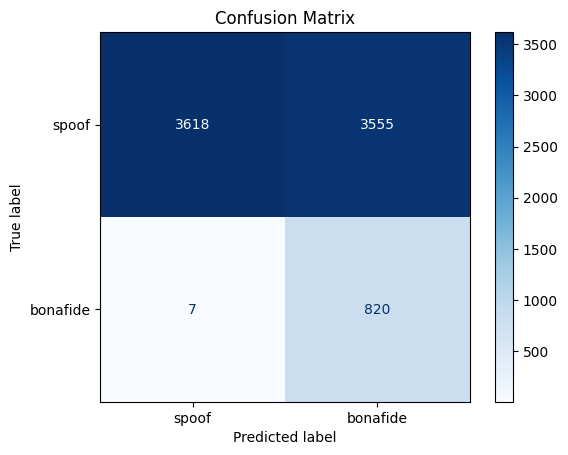

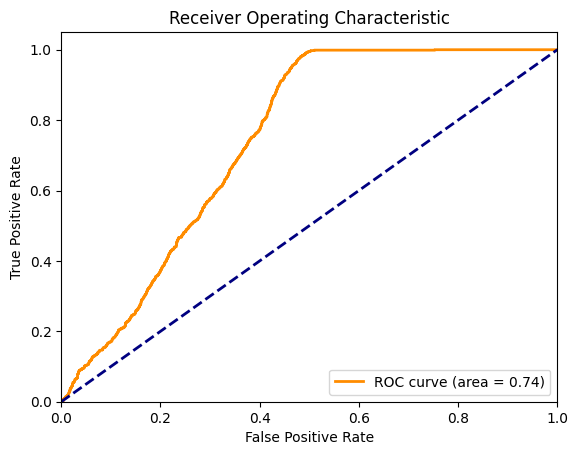

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test_set, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Predict using the loaded model
y_pred_prob = outputs[:, 1].numpy()  # Extract the probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_set, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 6. Silence Visualization

In [27]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)

# Print some examples
print("Number of training samples:", len(train_labels))
print("Training example label:", list(train_labels.items())[:5])

Number of training samples: 25380
Training example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]


In [29]:
import numpy as np
import librosa
import os
from tqdm import tqdm

# Function to detect silent segments in a Mel spectrogram
def detect_silent_segments(mel_spectrogram, threshold=-40):
    """
    Detects silent segments in a Mel spectrogram based on a dB threshold.

    Args:
        mel_spectrogram (np.array): Mel spectrogram (dB-scaled).
        threshold (float): Energy threshold (in dB) to define silence.

    Returns:
        silent_frames (list of tuples): List of (start_frame, end_frame) indices for silent segments.
    """
    frame_energies = np.mean(mel_spectrogram, axis=0)  # Compute average energy for each time frame

    # Detect frames below the energy threshold
    silent_frames = np.where(frame_energies < threshold)[0]

    # Convert frame indices into contiguous silent segments
    silent_segments = []
    if len(silent_frames) > 0:
        start = silent_frames[0]
        for i in range(1, len(silent_frames)):
            if silent_frames[i] != silent_frames[i - 1] + 1:
                end = silent_frames[i - 1]
                silent_segments.append((start, end))
                start = silent_frames[i]
        # Add the last segment
        end = silent_frames[-1]
        silent_segments.append((start, end))

    return silent_segments

# Function to process a dataset and extract silent segments

def process_dataset_for_silence(dataset_path, dataset_labels, output_dir, threshold=-60):
    """
    Processes a dataset to extract silent segments from Mel spectrograms.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.
        output_dir (str): Directory to save the silent segment metadata.
        threshold (float): Energy threshold (in dB) to define silence.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for file_name in tqdm(dataset_labels.keys(), desc="Processing dataset for silence"):
        file_path = os.path.join(dataset_path, file_name + ".flac")

        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Detect silent segments
            silent_segments = detect_silent_segments(mel_spectrogram_db, threshold=threshold)

            # Save silent segments to a file
            output_file = os.path.join(output_dir, file_name + "_silence.txt")
            with open(output_file, "w") as f:
                for start, end in silent_segments:
                    f.write(f"{start},{end}\n")

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Example usage of process_dataset_for_silence
process_dataset_for_silence(DATASET_TRAIN, train_labels, output_dir="deprecated/train_silence_metadata")

Processing dataset for silence: 100%|█████████████████████████████████████████████| 25380/25380 [07:15<00:00, 58.26it/s]


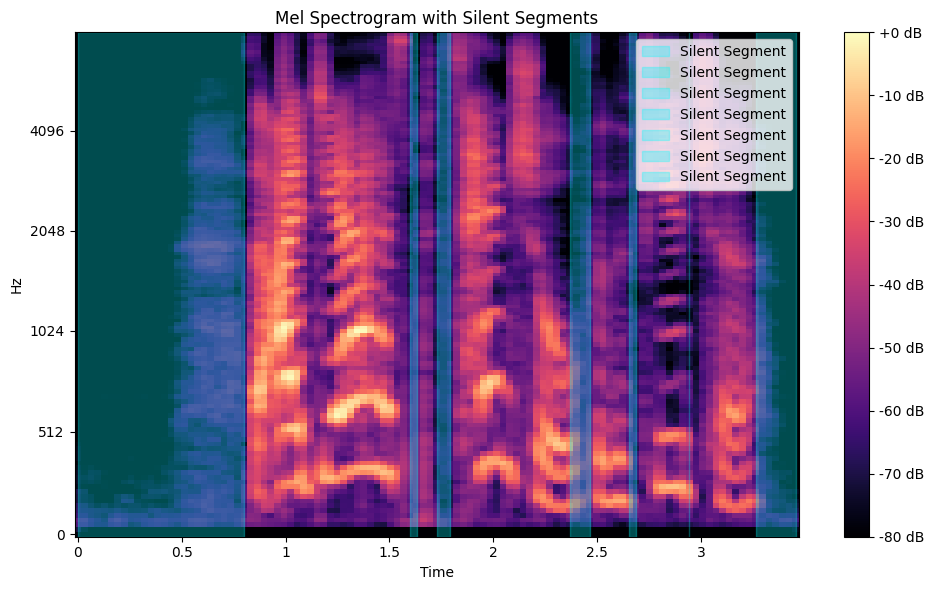

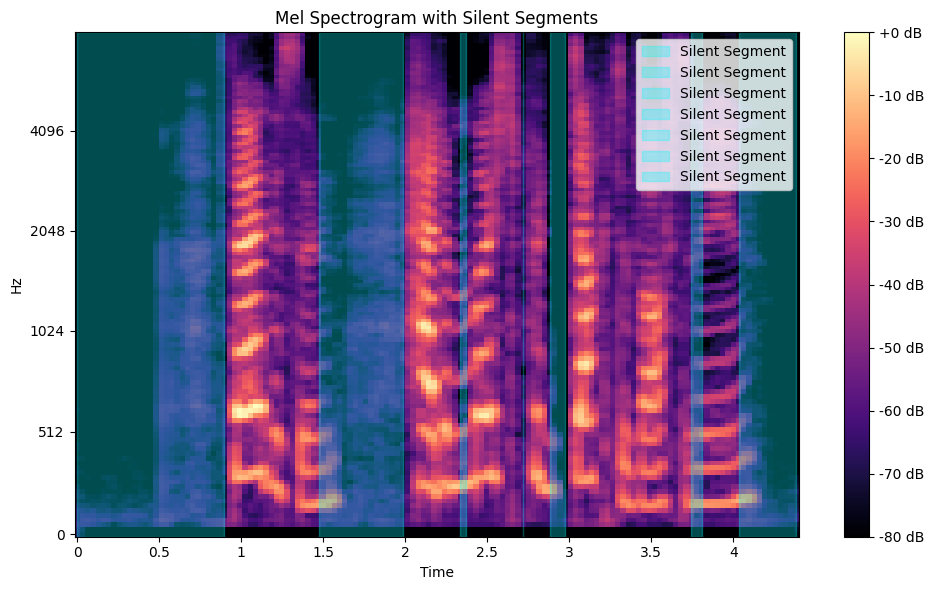

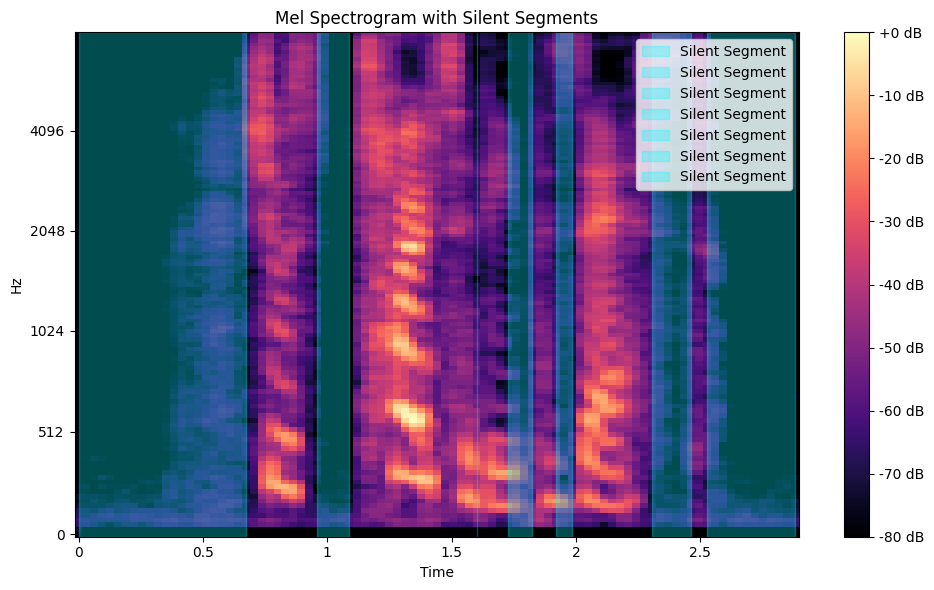

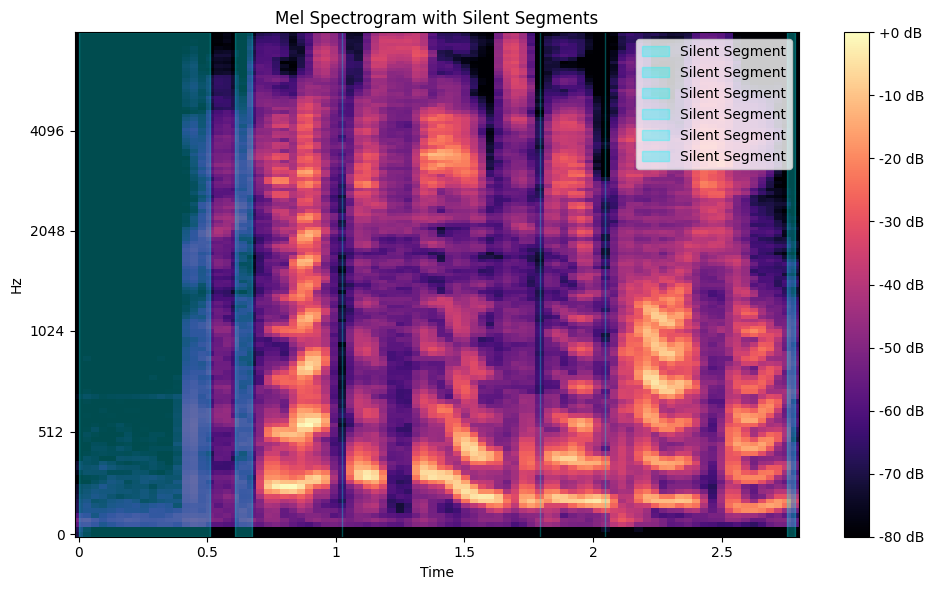

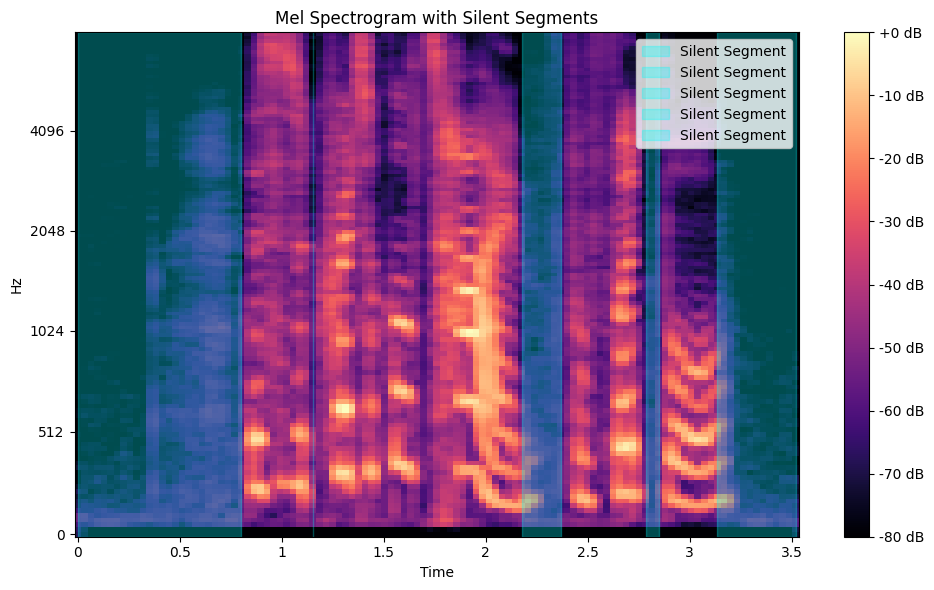

In [30]:
import os
import librosa
import librosa.display

def plot_silence_on_spectrogram(mel_spectrogram, silent_segments, sr, hop_length):
    """
    Plots a Mel spectrogram and highlights silent segments.

    Args:
        mel_spectrogram (np.array): Mel spectrogram (dB-scaled).
        silent_segments (list of tuples): List of (start_frame, end_frame) indices for silent segments.
        sr (int): Sample rate of the audio.
        hop_length (int): Hop length used in the Mel spectrogram.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram with Silent Segments')

    # Highlight silent segments
    for start, end in silent_segments:
        plt.axvspan(start * hop_length / sr, end * hop_length / sr, color='cyan', alpha=0.3, label='Silent Segment')

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# Load and plot the first spectrogram with silence for each audio
def plot_first_silence_spectrogram(dataset_path, dataset_labels, metadata_dir):
    """
    Loads and plots the first Mel spectrogram with silence highlighted for each audio in the dataset.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.
        metadata_dir (str): Directory containing silent segment metadata.

    Returns:
        None
    """
    for file_name in list(dataset_labels.keys())[:5]:  # Plot for first 5 audios
        audio_path = os.path.join(dataset_path, file_name + ".flac")
        metadata_path = os.path.join(metadata_dir, file_name + "_silence.txt")
        
        try:
            # Load audio and compute Mel spectrogram
            audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Load silent segment metadata
            silent_segments = []
            with open(metadata_path, "r") as f:
                for line in f:
                    start, end = map(int, line.strip().split(","))
                    silent_segments.append((start, end))
            
            # Plot the Mel spectrogram with silent segments
            plot_silence_on_spectrogram(mel_spectrogram_db, silent_segments, sr=SAMPLE_RATE, hop_length=512)

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Example Usage
plot_first_silence_spectrogram(DATASET_TRAIN, train_labels, metadata_dir="deprecated/train_silence_metadata")